# Imports

In [11]:
import sys

sys.path.append("..")
import pickle as pkl
from dataclasses import asdict, is_dataclass

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
from dacite import from_dict
from ipywidgets import interact

from calibration.benchmark.benchmark import BenchmarkResult, results_into_df
from calibration.feature_detector.visualization import show_boards, show_corners
from calibration.projector.board import gen_checkerboard_grid
from calibration.projector.camera import Camera

# pio.renderers.default = "svg"
from calibration.projector.projector import Projector
from calibration.solver.optimization.solve import solve as solve_optimization
from calibration.solver.scaramuzza.solve import solve as solve_scaramuzza

# from calibration.solver.solve import solve

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
with open("../babelcalib_results.pkl", "rb") as f:
    results = pkl.load(f)

In [13]:
df = results_into_df(results)

# EDA

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792 entries, 0 to 791
Data columns (total 27 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   input.ds_name                                 792 non-null    object 
 1   input.subds_name                              792 non-null    object 
 2   input.name                                    792 non-null    object 
 3   input.width                                   792 non-null    int64  
 4   input.height                                  792 non-null    int64  
 5   input.num_corners                             792 non-null    int64  
 6   input.encoding                                792 non-null    object 
 7   input.corners                                 792 non-null    object 
 8   input.image                                   792 non-null    object 
 9   features.board                                792 non-null    obj

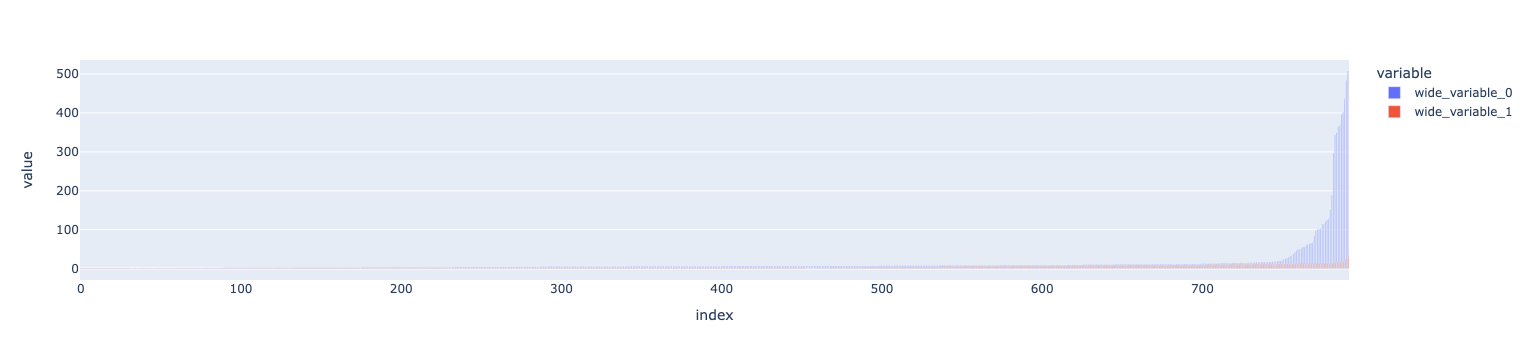

In [15]:
resultsO = sorted(
    [r for r in results if r.errors["Optimization"] is not None],
    key=lambda r: r.errors["Optimization"],
)
resultsS = sorted(
    [r for r in results if r.errors["Scaramuzza"] is not None],
    key=lambda r: r.errors["Scaramuzza"],
)

# df_ = df[~df["error"].isna()].sort_values("error")

px.bar(
    y=[
        sorted([r.errors["Optimization"] for r in resultsO]),
        sorted([r.errors["Scaramuzza"] for r in resultsS]),
    ],
    barmode="group",
)

In [16]:
results_ = sorted(results, key=lambda r: r.errors["Optimization"])

In [18]:
@interact
def f(i=(0, len(results)), solver=["Optimization", "Scaramuzza", "Live optimize"]):
    r = results_[i]
    w, h = r.input.image.size

    print(f"{i}, error_Optim={r.errors['Optimization']}")

    match solver:
        case "Optimization" | "Scaramuzza":
            try:
                proj = r.predictions[solver]
                error = r.errors[solver]
            except KeyError:
                print(f"Cannot get {solver} from {r.predictions.keys()}")
        case "Live optimize":
            proj = solve_optimization(
                r.features.corners,
                r.features.board,
                Camera(resolution=r.input.image.size),
            )
            error = r._calc_error(proj)
        case _:
            raise NotImplementedError
            
    print(f"Error {solver}: {error}")

    assert r.features is not None

    fig1 = show_boards(
        r.input.image, r.features.corners, r.features.board
    ).update_layout(height=h, width=w)
    display(fig1)
    display(
        px.scatter(
            r.features.board,
            x=0,
            y=1,
            color=range(r.features.board.shape[0]),
            title="Original board",
            # height=h,
            # width=w,
        )
    )
    board_ = proj.backproject(r.features.corners)
    display(
        px.scatter(
            board_,
            x=0,
            y=1,
            title="Backprojected board",
            # height=h,
            # width=w,
        )
    )
    display(
        # px.scatter(
        #     r.features.corners,
        #     x=0,
        #     y=1,
        #     title="Original corners",
        #     color=range(r.features.corners.shape[0]),
        #     range_x=[0, w],
        #     range_y=[0, h],
        #     # height=h,
        #     # width=w,
        # ).update_yaxes(autorange="reversed")
        show_boards(
        r.input.image, r.features.corners, r.features.board
    ).update_layout(height=h, width=w, title="Original corners")
    )


    try:
        max_point_img_space = np.r_[proj.camera.resolution, 1]
        max_point = np.linalg.inv(proj.camera.intrinsic_matrix) @ max_point_img_space
        max_r = float(np.linalg.norm(max_point[:2]))
        corners_ = proj.project(r.features.board, max_r * 10)
        # corners_ = r.prediction.project(r.features.board, 100)
        display(
            # px.scatter(
            #     corners_,
            #     x=0,
            #     y=1,
            #     title="Projected corners",
            #     range_x=[0, w],
            #     range_y=[0, h],
            #     # height=h,
            #     # width=w,
            # ).update_yaxes(autorange="reversed")
                display(
        # px.scatter(
        #     r.features.corners,
        #     x=0,
        #     y=1,
        #     title="Original corners",
        #     color=range(r.features.corners.shape[0]),
        #     range_x=[0, w],
        #     range_y=[0, h],
        #     # height=h,
        #     # width=w,
        # ).update_yaxes(autorange="reversed")
        show_boards(
        r.input.image, corners_, r.features.board
    ).update_layout(height=h, width=w, title="Projected corners")
    )
        )
    except ValueError:
        print("Cannot project")

    print(proj.R)
    print(proj.t)
    print(proj.lambdas)

interactive(children=(IntSlider(value=396, description='i', max=792), Dropdown(description='solver', options=(…

396, error_Optim=3.2996285566464305
iteration: 0, loss: 84.46634674072266
iteration: 1000, loss: 4.393320083618164
iteration: 2000, loss: 1.9037575721740723
iteration: 3000, loss: 0.8502781391143799
iteration: 4000, loss: 0.47045716643333435
iteration: 5000, loss: 0.41384458541870117
iteration: 6000, loss: 0.39148035645484924
iteration: 7000, loss: 0.2261718362569809
iteration: 8000, loss: 0.06996745616197586
iteration: 9000, loss: 0.02366768941283226
iteration: 10000, loss: 0.007972003892064095
iteration: 11000, loss: 0.0023888861760497093
iteration: 12000, loss: 0.0005844526458531618
iteration: 13000, loss: 0.0001296512346016243
iteration: 14000, loss: 5.202339525567368e-05
iteration: 15000, loss: 4.371252725832164e-05
iteration: 16000, loss: 4.3134234147146344e-05
iteration: 17000, loss: 4.337784048402682e-05
iteration: 18000, loss: 4.3093852582387626e-05
iteration: 19000, loss: 4.326098132878542e-05
iteration: 20000, loss: 4.319233994465321e-05
iteration: 21000, loss: 4.30912405136

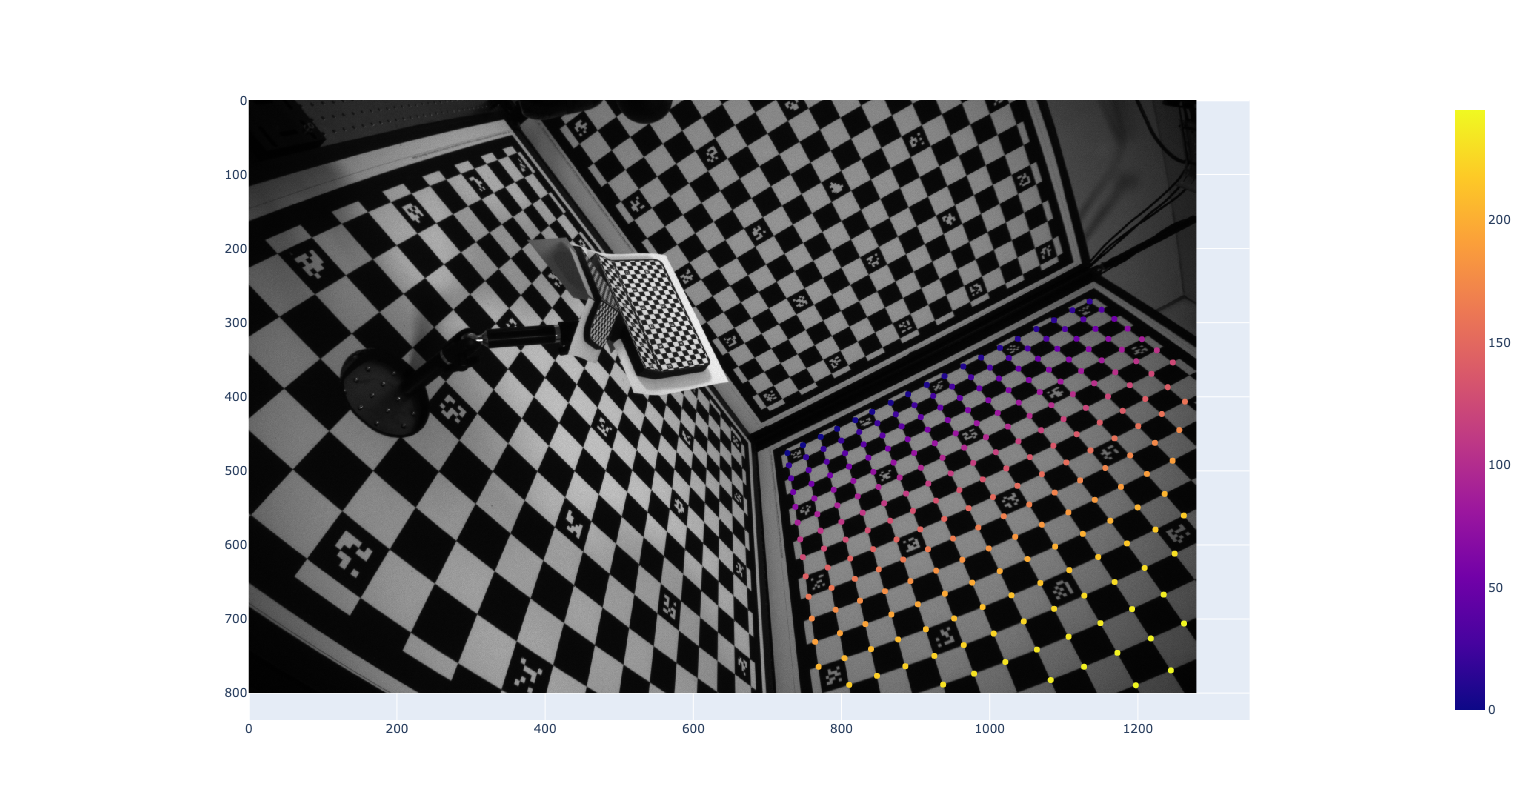

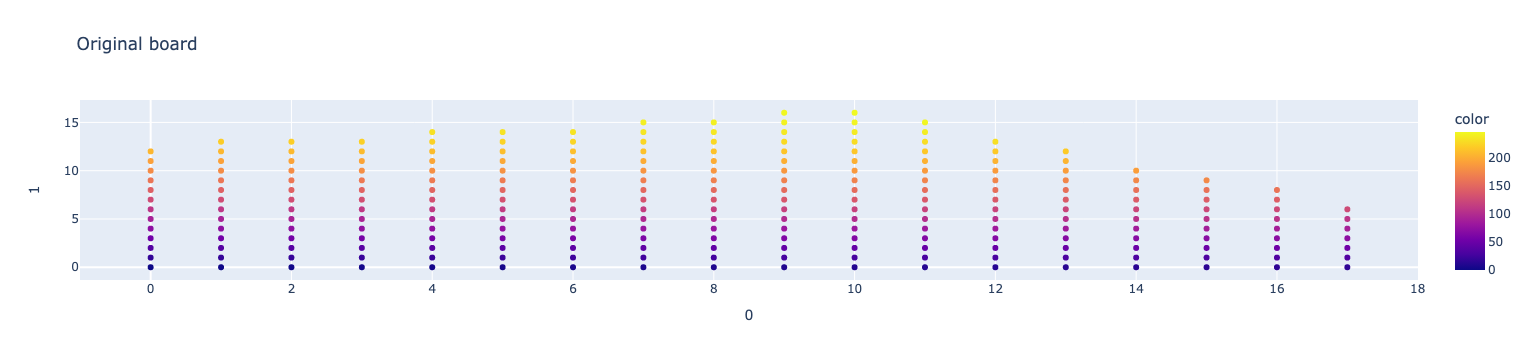

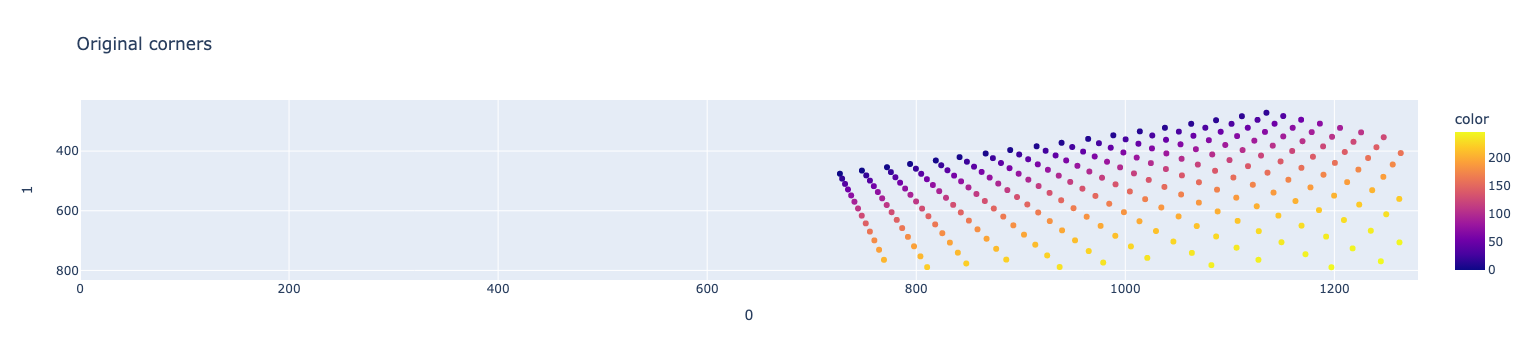

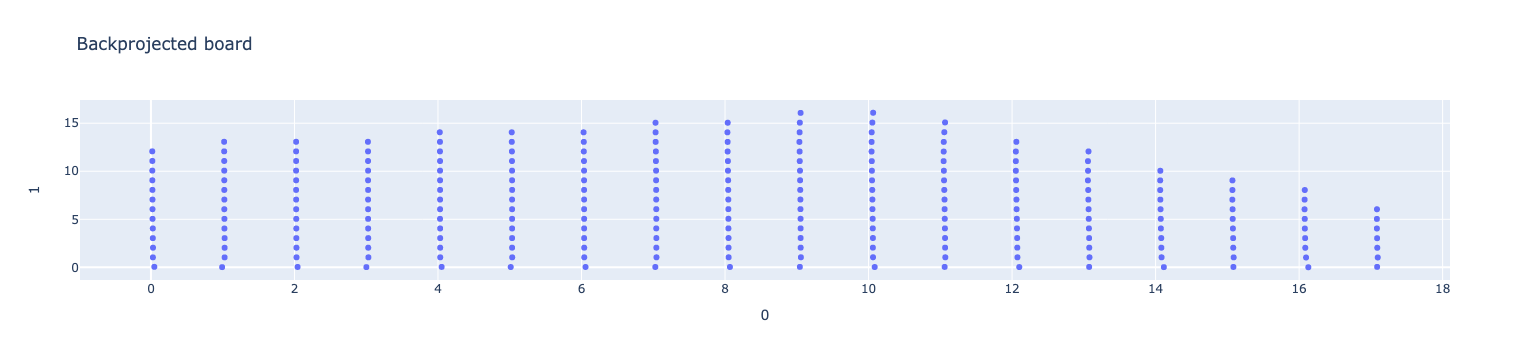

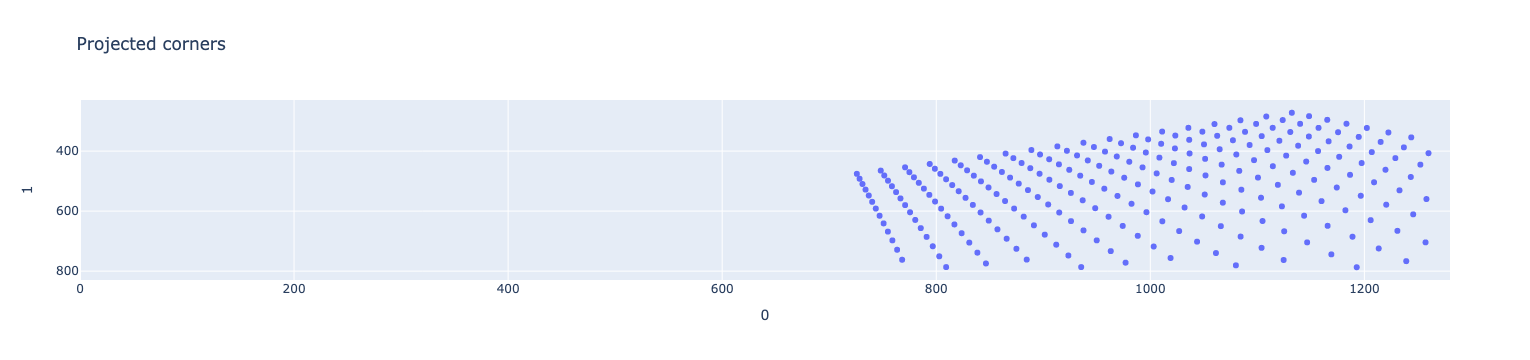

[[ 0.84845424 -0.0022346   0.529264  ]
 [-0.44432616  0.5403327   0.71457314]
 [-0.28757542 -0.8414485   0.45745468]]
[ 3.413734   2.9744756 27.23959  ]
[-0.18698254 -0.0060345 ]


In [42]:
i = 396
solver = "Live optimize"
r = results[i]
w, h = r.input.image.size

print(f"{i}, error_Optim={r.errors['Optimization']}")

match solver:
    case "Optimization" | "Scaramuzza":
        try:
            proj = r.predictions[solver]
            error = r.errors[solver]
        except KeyError:
            print(f"Cannot get {solver} from {r.predictions.keys()}")
    case "Live optimize":
        proj = solve_optimization(
            r.features.corners,
            r.features.board,
            Camera(resolution=r.input.image.size),
        )
        error = r._calc_error(proj)
    case _:
        raise NotImplementedError

assert r.features is not None

fig1 = show_boards(
    r.input.image, r.features.corners, r.features.board
).update_layout(height=h, width=w)
display(fig1)
display(
    px.scatter(
        r.features.board,
        x=0,
        y=1,
        color=range(r.features.board.shape[0]),
        title="Original board",
        # height=h,
        # width=w,
    )
)
display(
    px.scatter(
        r.features.corners,
        x=0,
        y=1,
        title="Original corners",
        color=range(r.features.corners.shape[0]),
        range_x=[0, w],
        range_y=[0, h],
        # height=h,
        # width=w,
    ).update_yaxes(autorange="reversed")
)

board_ = proj.backproject(r.features.corners)
display(
    px.scatter(
        board_,
        x=0,
        y=1,
        title="Backprojected board",
        # height=h,
        # width=w,
    )
)
try:
    max_point_img_space = np.r_[proj.camera.resolution, 1]
    max_point = np.linalg.inv(proj.camera.intrinsic_matrix) @ max_point_img_space
    max_r = float(np.linalg.norm(max_point[:2]))
    corners_ = proj.project(r.features.board, max_r * 10)
    # corners_ = r.prediction.project(r.features.board, 100)
    display(
        px.scatter(
            corners_,
            x=0,
            y=1,
            title="Projected corners",
            range_x=[0, w],
            range_y=[0, h],
            # height=h,
            # width=w,
        ).update_yaxes(autorange="reversed")
    )
except ValueError:
    print("Cannot project")

print(proj.R)
print(proj.t)
print(proj.lambdas)

# 585

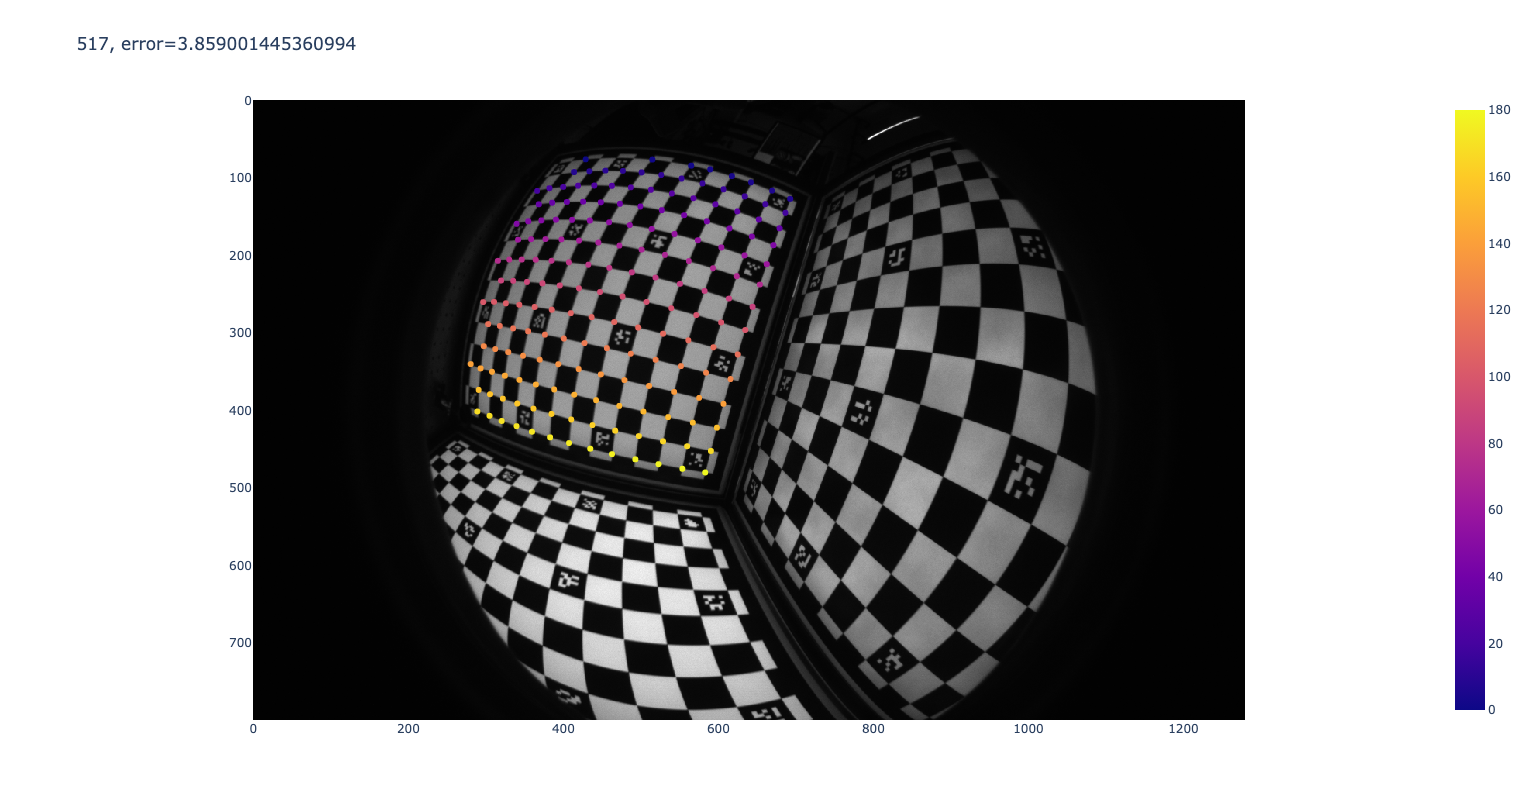

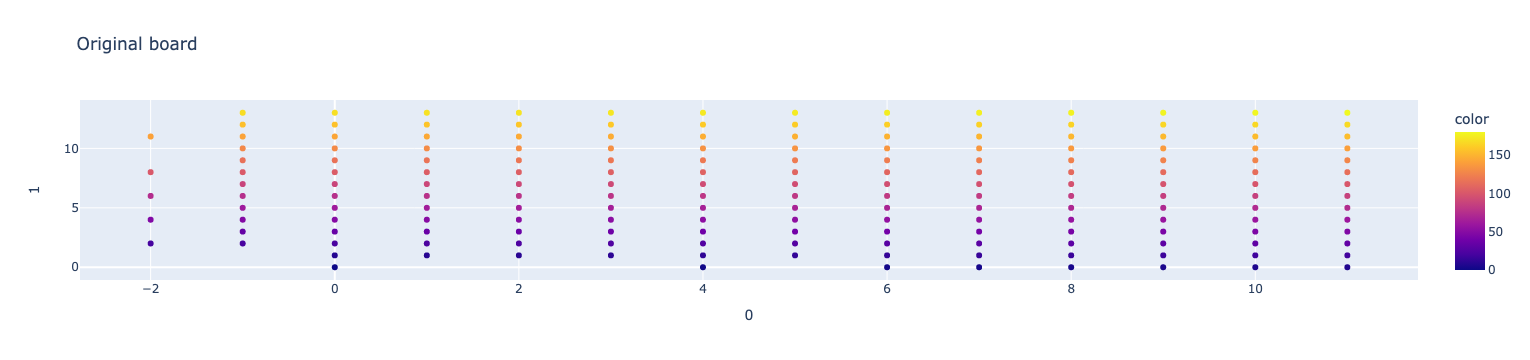

In [11]:
i = 517

r = results_[i]
w, h = r.input.image.size

fig1 = show_boards(r.input.image, r.features.corners, r.features.board).update_layout(
    title=f"{i}, error={r.error}", height=h, width=w
)
display(fig1)
display(
    px.scatter(
        r.features.board,
        x=0,
        y=1,
        color=range(r.features.board.shape[0]),
        title="Original board",
        # height=h,
        # width=w,
    )
)

In [12]:
r.input.ds_name, r.input.subds_name, r.input.name

('OV/cube/ov00', 'train', 'ov00/0031.pgm')

In [13]:
resolution = np.array(r.input.image.size)
sensor_size = np.array([36, 36.0 * resolution[1] / resolution[0]])
focal_length = 35
camera = Camera(
    focal_length=focal_length, resolution=resolution, sensor_size=sensor_size
)

In [14]:
X = r.features.board
x = r.features.corners

proj = solve_optimization(x, X, camera)

In [15]:
proj

Projector(R=array([[ 0.88874955, -0.2920921 , -0.35327955],
       [ 0.21656476,  0.94681088, -0.23801021],
       [ 0.40400983,  0.13502356,  0.9047346 ]]), t=array([ -7.91088414, -12.08049614,  29.99064251]), lambdas=array([ -2.41963049, -11.07207703]), camera=Camera(focal_length=35, sensor_size=array([36. , 22.5]), resolution=array([1280,  800]), skew=0.0))

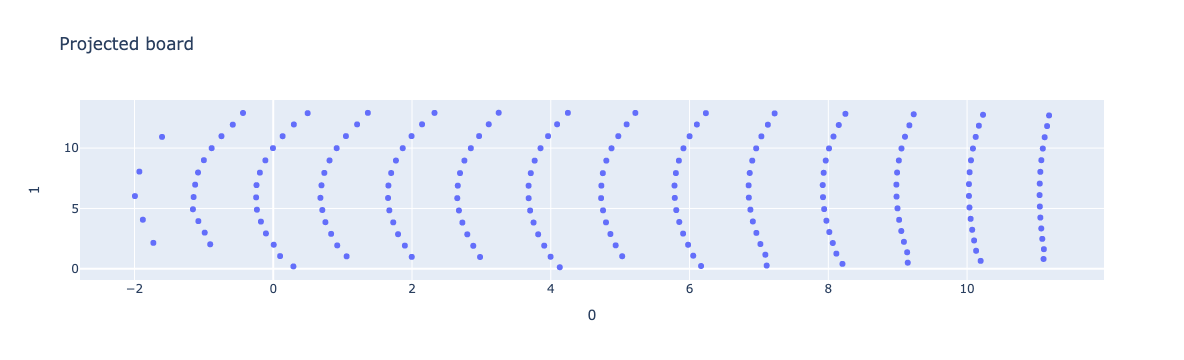

In [16]:
X_ = proj.backproject(x)
display(
    px.scatter(
        X_,
        x=0,
        y=1,
        title="Projected board",
        # range_x=[0, w],
        # range_y=[0, h],
        # height=h,
        # width=w,
    )
)

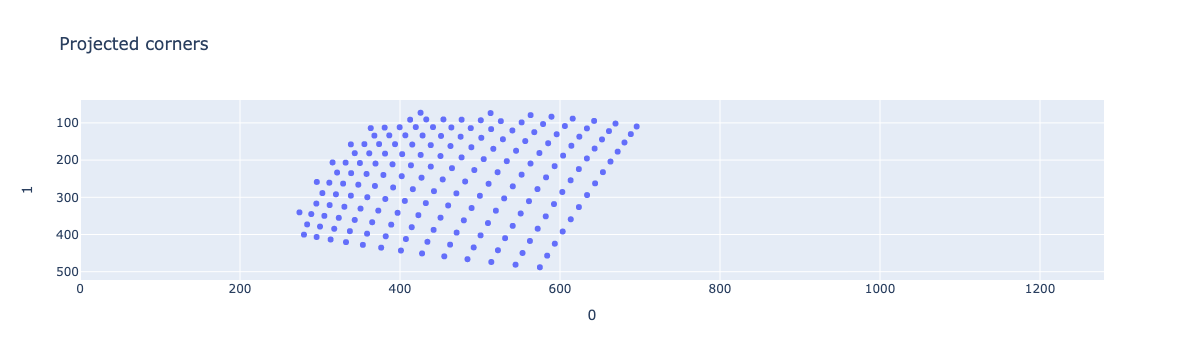

In [17]:
x_ = proj.project(X, 100000)
display(
    px.scatter(
        x_,
        x=0,
        y=1,
        title="Projected corners",
        range_x=[0, w],
        range_y=[0, h],
        # height=h,
        # width=w,
    ).update_yaxes(autorange="reversed")
)